In [342]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [316]:
nProbes = 1000
file = open('transitionRate.txt', 'r')

In [317]:
# read tetra info and initial probe info
line1 = file.readline()
line2 = file.readline()

tetraId = [int(i) for i in line1.split(' ')[:-1]]
tetraId.append(-1)
numProbes = [int(i) for i in line2.split(' ')[:-1]]
numProbes.append(nProbes - sum(numProbes))

In [318]:
# read jumps info
lines = file.readlines()
t = []
s1 = []
s2 = []

for line in lines:
    data = line.strip().split()
    tTmp = int(data[0])

    for i in range(len(data[1:])):
        s1Tmp, s2Tmp = data[1:][i].split(',')
        t.append(tTmp)
        s1.append(int(s1Tmp))
        s2.append(int(s2Tmp))

jumps = pd.DataFrame({'t': t, 's1': s1, 's2': s2})
jumps = jumps.sort_values(by=['t', 's1', 's2'])

In [319]:
# create population dataset
# Improved version: vectorized update using numpy for better time complexity

# Prepare initial population as a numpy array
z = [(x, y) for x, y in zip(tetraId, numProbes)]
z.sort()
tetraId, numProbes = zip(*z)
tetraId = list(tetraId)
numProbes = np.array(numProbes)

# Create a mapping from tetraId to column index
tetraId_to_idx = {tid: idx for idx, tid in enumerate(tetraId)}

# Prepare jumps as numpy arrays for fast indexing
jumps_sorted = jumps.sort_values(by=['t', 's1', 's2'])
t_arr = jumps_sorted['t'].to_numpy()
s1_arr = jumps_sorted['s1'].to_numpy()
s2_arr = jumps_sorted['s2'].to_numpy()

# Map s1 and s2 to column indices
s1_idx = np.array([tetraId_to_idx[s] for s in s1_arr])
s2_idx = np.array([tetraId_to_idx[s] for s in s2_arr])

n_steps = t_arr.max() + 1
n_tetra = len(tetraId)
pop_matrix = np.zeros((n_steps + 1, n_tetra), dtype=int)
pop_matrix[0] = numProbes

# For each time step, apply all jumps at that time in a vectorized way
for t in range(n_steps):
    pop_matrix[t + 1] = pop_matrix[t]
    mask = (t_arr == t)
    # Count net changes for each tetraId at this time step
    if np.any(mask):
        # For all jumps at this t, subtract 1 from s1, add 1 to s2
        np.subtract.at(pop_matrix[t + 1], s1_idx[mask], 1)
        np.add.at(pop_matrix[t + 1], s2_idx[mask], 1)

population = pd.DataFrame(pop_matrix, columns=tetraId)

(0.0, 250.0)

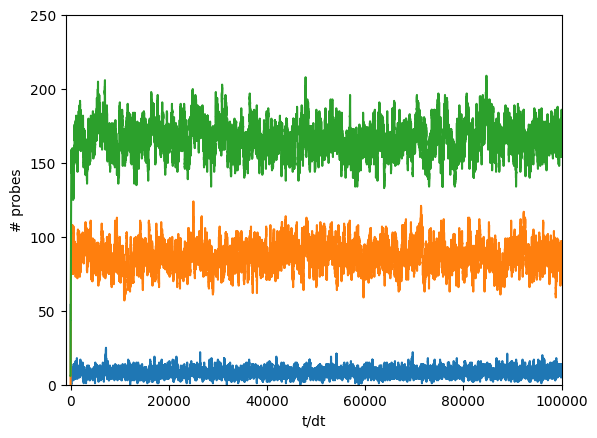

In [ ]:
plt.plot(population.iloc[:, 7])
plt.plot(population.iloc[:, 1])
plt.plot(population[population.iloc[-1].idxmax()])

plt.xlabel('t/dt')
plt.ylabel('# probes')
plt.xlim(-1e3, 1e5)
plt.ylim(0, 250)

In [ ]:
N = population.iloc[int(2e4):].sum()
jumps = jumps[jumps['t'] > int(2e4)]
Jij = np.zeros((len(tetraId), len(tetraId)))
for i in range(len(tetraId)):
    for j in range(len(tetraId)):
        Jij[i, j] = jumps[(jumps['s1'] == tetraId[i]) & (jumps['s2'] == tetraId[j])].shape[0]

In [ ]:
Tij = Jij.copy()
for i in range(len(tetraId)):
    for j in range(len(tetraId)):
        if i == j:
            Tij[i, j] = 0
        else:
            if N.values[i] == 0:
                Tij[i,j] = 0
            else:
                Tij[i, j] = Tij[i, j] / N.values[i]
    Tij[i, i] = -Tij[i, :].sum()

In [ ]:
tij = Tij.reshape(1, -1)
tij = tij[np.where(tij > 0)]
tij = np.log(tij)

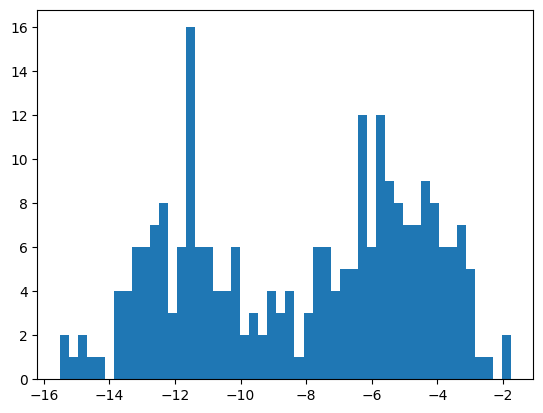

In [397]:
plt.hist(tij, bins=50);